In [6]:
%matplotlib inline
import glob
import _init_paths
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import caffe, os, sys, cv2
import argparse
from fast_rcnn.config import cfg, cfg_from_file, cfg_from_list
from datasets.config import CLASS_SETS

def _get_ann_file():
        prefix = 'image_info' 
        return os.path.join("/root/data/coco/", 'annotations',
                        prefix + '_' + "test2014" + '.json')

CLASSES = CLASS_SETS["coco"]

In [7]:


def vis_detections(im, class_names, dets_list, thresh=0.5):
    """Draw detected bounding boxes."""
    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(im, aspect='equal')
    
    for class_name, dets in zip(class_names, dets_list):


        for i in range(len(dets)):
            bbox = dets[i, :4]
            score = dets[i, -1]

            ax.add_patch(
                plt.Rectangle((bbox[0], bbox[1]),
                              bbox[2] - bbox[0],
                              bbox[3] - bbox[1], fill=False,
                              edgecolor='red', linewidth=3.5)
                )
            ax.text(bbox[0], bbox[1] - 2,
                    '{:s} {:.3f}'.format(class_name, score),
                    bbox=dict(facecolor='blue', alpha=0.5),
                    fontsize=14, color='white')

        ax.set_title(('{} detections with '
                      'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                      thresh),
                      fontsize=14)
    #plt.axis('off')
    #plt.tight_layout()
    #plt.draw()

def demo(net, im_file):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
   
    im = cv2.imread(im_file)
    print(im.shape)
    #int("Hallo")
    

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    _t = {'im_preproc': Timer(), 'im_net' : Timer(), 'im_postproc': Timer(), 'misc' : Timer()}
    scores, boxes = im_detect(net, im, _t)
   
   
    # Visualize detections for each class
    CONF_THRESH = 0.5
    NMS_THRESH = 0.3
    
    cls_list = []
    dets_list = []
    
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]   
        
        cls_scores = scores[:, cls_ind]
        
        
        keep = cls_scores > CONF_THRESH
        cls_scores = cls_scores[keep]
        cls_boxes = cls_boxes[keep, :]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        
        
        
        
        
        cls_list.append(cls)
        dets_list.append(dets)
    timer.toc()
    print ('Detection took {:.3f}s for '
       '{:d} object proposals').format(timer.total_time, boxes.shape[0])

        
    vis_detections(im, cls_list, dets_list, thresh=CONF_THRESH)



if __name__ == '__main__':
    #cfg.TEST.HAS_RPN = True
   

    prototxt = "../models/pvanet/lite/coco_test.prototxt"
    caffemodel = "/root/data/PVA-RC/rc4_iter_160000.caffemodel"
    cfg_from_file("../models/pvanet/cfgs/submit_1019.yml")
    caffe.set_mode_gpu()
    caffe.set_device(0)
    cfg.GPU_ID = 0
    net = caffe.Net(prototxt, caffemodel, caffe.TEST)

    print '\n\nLoaded network {:s}'.format(caffemodel)

    # Warmup on a dummy image
    #m = 128 * np.ones((300, 500, 3), dtype=np.uint8)
    #for i in xrange(2):
        #_t = {'im_preproc': Timer(), 'im_net' : Timer(), 'im_postproc': Timer(), 'misc' : Timer()}
        #_, _= im_detect(net, im, _t)
    
   



Loaded network /root/data/PVA-RC/rc4_iter_160000.caffemodel


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/demo/suitcase/071008_luggage_hmed_12p.grid-6x2.jpg
(339, 474, 3)
Detection took 0.295s for 200 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/demo/suitcase/bu_luggage23_0030_lm.jpg
(494, 324, 3)
Detection took 0.054s for 200 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/demo/suitcase/men-carrying-too-much-carryon-luggage.jpg
(315, 225, 3)
Detection took 0.049s for 200 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/demo/suitcase/_100483934.jpg
(4048, 2640, 3)
Detection took 0.365s for 170 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/demo/suitcase/shutterstock_128647436.jpg
(3813, 5517, 3)
Detection took 2.099s for 200 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/demo/suitcase/carry-onluggage.jpg
(305, 480, 3)
Detection took 0.060s for 200 o

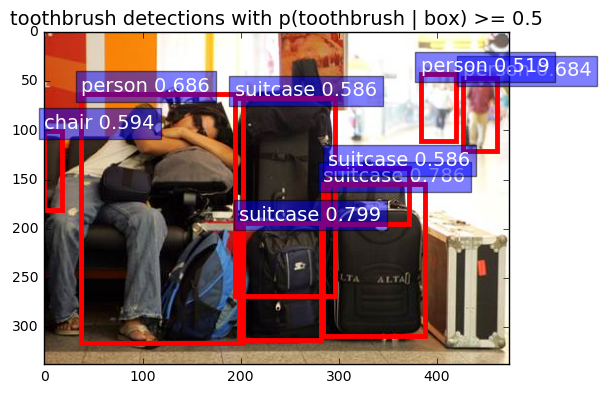

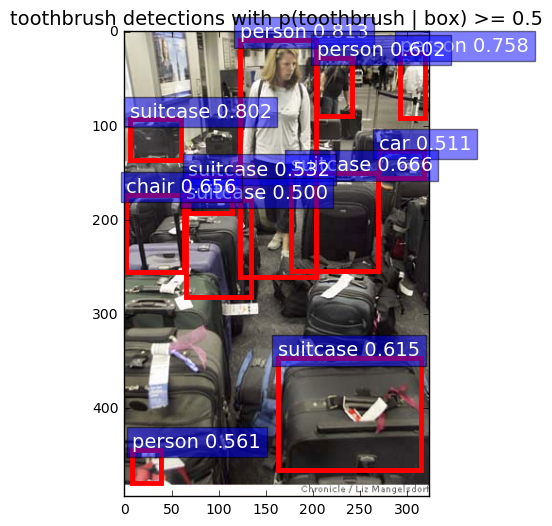

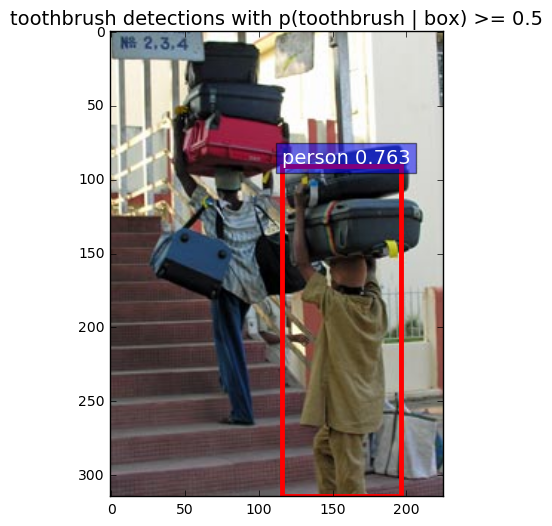

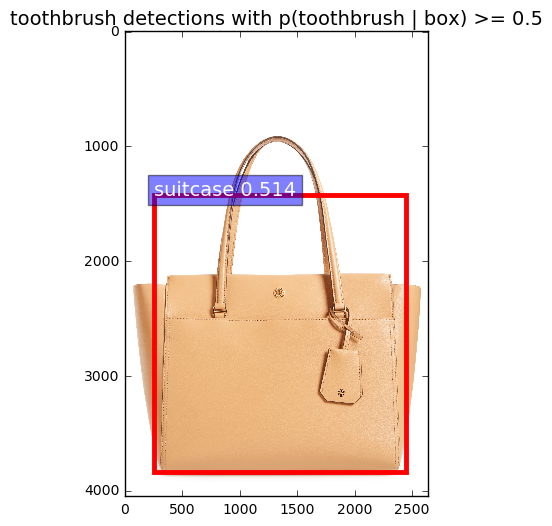

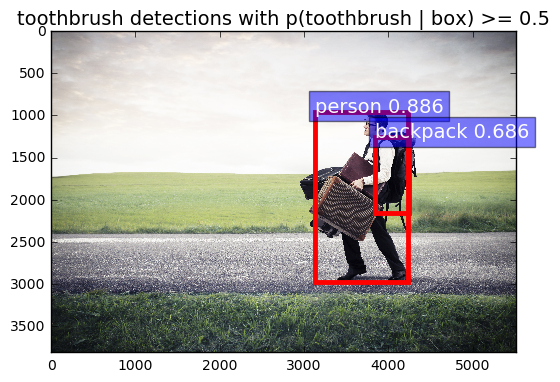

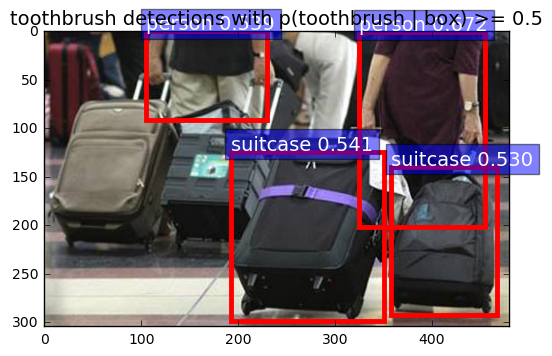

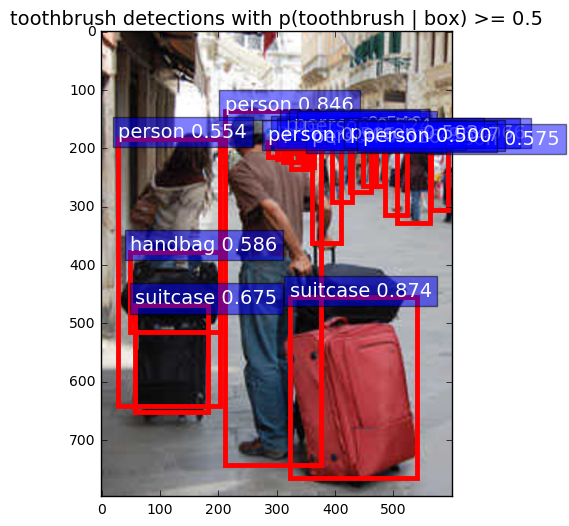

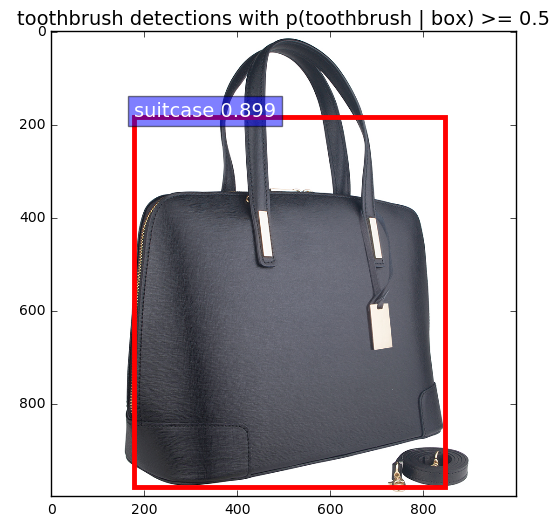

In [8]:
im_names = glob.glob("/root/data/demo/suitcase/*.jpg")
for im_name in im_names:
    print '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
    print 'Demo for data/demo/{}'.format(im_name)
    demo(net, im_name)

plt.show()